<a href="https://colab.research.google.com/github/andreasfloros/ARM-ML-Embedded/blob/main/audio_classifier_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio classifier pipeline

### 1) Download and untar dataset directly to colab:

To change between datasets change the url to one which downloads a .tar file.

**Note 1: If the audio_data folder already exists in your collab session running the following cell will give an error. That is not a problem, run it anyway.**

**Note 2: For the Speech Commands dataset you MUST delete the README.md file in the audio_data/background_noise subfolder. This is the only file not in .wav format in the entire directory and since .md files cannot be read by the audio processing library not deleting it will cause the algorithms to fail when processing the dataset!**

In [1]:
import os
import requests
import tarfile

DATASET_ROOT_DIR = 'audio_data/'
os.mkdir(DATASET_ROOT_DIR)
url = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
target_path = 'audio_data/dataset.tar.gz'

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())

tar = tarfile.open(target_path, "r:gz")
tar.extractall(path='audio_data/')
tar.close()

### 2) Preprocess dataset:

We iterate through the entire dataset, process every audio track using a processing method (either FFT, STFT, or MFCC), and store all of them in a JSON file. Currently, the user is able to control the processing method, expected duration of the audio tracks, the sample rate, as well as other values related to the processing methods.

Potentially, the user might also be able (in the future) to automatically go through all processing methods and use the one which optimizes the current model accuracy.

The process explained above can be completed through the following steps.

**Step 1:** Import necessary libraries

In [2]:
import os
import librosa
import math
import json
import numpy as np

**Step 2:** Function to extend/cut tracks appropriately so that all contain the expected number of samples

In [3]:
def make_track_correct_size(signal, expected_num_samples_per_track):

    # print('Original track length: {}'.format(len(signal)))
    # if track is shorter than expected, append it with zeros
    if len(signal) < expected_num_samples_per_track:
      num_zeros_to_pad = expected_num_samples_per_track - len(signal)
      zeros = num_zeros_to_pad * [0.]
      extended_signal = np.append(signal, zeros)
      return extended_signal

    # if track is longer than expected, truncate it
    elif len(signal) > expected_num_samples_per_track:
      return signal[:expected_num_samples_per_track]

    # else return the original track 
    else:
      return signal

**Step 3:** Define function to process a single track using the method specified as input and return the data structure containing the result. This function will be called for all tracks within the dataset

In [4]:
def audio_track_to_features(signal, processing_method, sample_rate, window_size, window_stride, num_mfcc):

  if processing_method == 'fft':
    # perform Fast Fourier Transform (FFT)
    fft = np.fft.fft(signal)

    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)

    # the spectrum is symmetrical with respect to sample_rate / 2
    # so take half of the spectrum and frequency arrays
    # therefore len(half_spectrum) = sample_rate / 2
    half_spectrum = spectrum[:int(len(spectrum)/2)]

    # average every 10 samples to reduce size of array to 1 / 10 of its original size
    averaged = np.mean(half_spectrum.reshape(-1, 20), axis=1)

    # convert to a 2D shape to fit the neural network's Conv2D layer input shape specs
    two_dimentional = np.reshape(averaged, (1, len(averaged)))
    return two_dimentional


  elif processing_method == 'stft':
    # perform Short Time Fourier Transform (STFT)
    stft = librosa.stft(signal, n_fft=window_size, hop_length=window_stride)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)

    # transpose and return the spectrogram matrix
    transposed_spectrogram = spectrogram.transpose()
    return transposed_spectrogram


  else: # mfcc
    # perform Mel-Frequency Cepstral Coefficients (MFCC)
    mfcc = librosa.feature.mfcc(signal, 
                                sr = sample_rate, 
                                n_fft = window_size, 
                                n_mfcc = num_mfcc,
                                hop_length = window_stride)
    # transpose and return the mfcc matrix
    transposed_mfcc = mfcc.T
    return transposed_mfcc

**Step 4:** Define function to process every audio track and create a JSON file with the entire processed dataset

In [5]:
def preprocess_entire_dataset(dataset_path, json_path, processing_method, sample_rate, expected_duration, window_size, window_stride, num_mfcc):
  # expected duration is in seconds
  expected_num_samples_per_track = expected_duration * sample_rate
  
  # dictionary to later be converted to final json file
  data = {
      'mapping' : [],
      'features' : [],
      'labels' : []
  }

  # iterate through all subfolders
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

    # # ensure we are not at the dataset root directory
    # # (os.walk provides this directory as well)
    if dirpath is not DATASET_ROOT_DIR:

      # obtain word labels
      dirpath_components = dirpath.split('/') # audio_data/left => ['audio_data', 'left']
      word_label = dirpath_components[-1]
      data['mapping'].append(word_label)
      print('Processing {}'.format(word_label))

      # access and process files for current word
      for f in filenames:
        
        # load audio file
        file_path = os.path.join(dirpath, f)
        signal, sample_rate = librosa.load(file_path, sr=sample_rate)

        # extend or cut signal to be equal to the expected size
        signal_correct_size = make_track_correct_size(signal, expected_num_samples_per_track)

        # obtain the features of the audio track using the function defined above
        track_features = audio_track_to_features(signal = signal_correct_size, 
                                                 processing_method = 'fft', 
                                                 sample_rate = sample_rate, 
                                                 window_size = window_size, 
                                                 window_stride = window_stride, 
                                                 num_mfcc = 13)
        
        # append the audio track features to the features field of the dictionary
        data['features'].append(track_features.tolist())

        # append the current index-1 as the label of this track
        # the -1 comes from the fact that the index 0 refers to the dataset root directory,
        # the only directory which does not have a label
        data['labels'].append(i-1)
        # print('file_path: {}'.format(file_path))


  # create the json file from the dictionary
  with open(json_path, 'w') as fp:
    json.dump(data, fp, indent=4)

**Step 5:** Before running these functions with the code in the following cell we must delete the '.ipynb_checkpoint' files which might otherwise be considered as part of the dataset and interfere with training the model.

In [6]:
rm -rf `find -type d -name .ipynb_checkpoints`

**Step 6:** Run the function above with the desired parameters

**As aforementioned, before running this, ensure that you have deleted the README.md file in the audio_data/background_noise directory.**

In [7]:
JSON_PATH = DATASET_ROOT_DIR + 'data.json'
PROCESSING_METHOD = 'fft'
SAMPLE_RATE = 16000
EXPECTED_DURATION = 1 # in seconds
WINDOW_SIZE_SAMPLES = 512
WINDOW_STRIDE_SAMPLES = 320
MFCC_COEFF_NUMBER = 13


preprocess_entire_dataset(dataset_path = DATASET_ROOT_DIR, 
                   json_path = JSON_PATH, 
                   processing_method = PROCESSING_METHOD,
                   sample_rate = SAMPLE_RATE, 
                   expected_duration = EXPECTED_DURATION, 
                   window_size = WINDOW_SIZE_SAMPLES, 
                   window_stride = WINDOW_STRIDE_SAMPLES, 
                   num_mfcc = MFCC_COEFF_NUMBER)

Processing _background_noise_
Processing on
Processing follow
Processing left
Processing bed
Processing stop
Processing backward
Processing five
Processing six
Processing happy
Processing go
Processing visual
Processing nine
Processing wow
Processing marvin
Processing four
Processing learn
Processing tree
Processing yes
Processing house
Processing eight
Processing sheila
Processing down
Processing two
Processing bird
Processing three
Processing off
Processing zero
Processing one
Processing forward
Processing dog
Processing no
Processing right
Processing cat
Processing seven
Processing up


### 3) Build and evaluate model

preparing dataset...
loading data...
(63500, 1, 400)
X_train.shape: (63500, 1, 400, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 400, 16)        592       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 200, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 200, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 200, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 100, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 100, 32)        128       
___________________________________

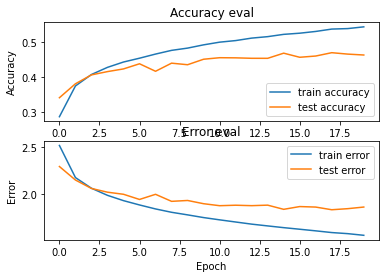

In [8]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt



def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    print('loading data...')

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data['features'])
    y = np.array(data['labels'])
    return X, y



def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()



def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    print('preparing dataset...')

    # load data
    X, y = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    print(X_train.shape)
    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test



def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(16, (6, 6), activation='relu', input_shape=input_shape, padding='same'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    # model.add(keras.layers.Flatten())
    # model.add(keras.layers.Dense(10, activation='relu'))
    # model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(37, activation='softmax'))

    return model



def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))



if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    print('X_train.shape: {}'.format(X_train.shape))
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=20)

    # plot accuracy/error for training and validation
    plot_history(history)

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

827/827 - 8s - loss: 1.8415 - accuracy: 0.4749

Test accuracy: 0.4749234616756439
Target: 26, Predicted label: [26]


### 4) Save model and convert to desired formats.

Save keras model as an .h5 file.

In [ ]:
model.save("all_words_fft.h5")

Convert the model to a quantized tflite model.

In [ ]:
import tensorflow as tf
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)


converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_generator():
  for value in X_test:
    yield [np.array(value, dtype = np.float32, ndmin=4)]

converter.representative_dataset = representative_dataset_generator

tflite_model = converter.convert()

# Save the model to disk
open("all_words_fft.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("all_words_fft.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpiw9ksaq5/assets
Model is 420788 bytes


Convert model from tflite file to byte array for deployment on Arduino.

In [ ]:
!apt-get -qq install xxd
!xxd -i all_words_fft.tflite > all_words_fft.cc
!cat all_words_fft.cc